In [350]:
# Imports
import pandas as pd
import numpy as np

# machine learning
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# xgboost
import xgboost as xgb

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [351]:
# 自定義的function

# 算 accuracy, precision, recall
def performance(clf, X_train, Y_train, cv_num = 4):
    scores = cross_val_score(clf, X_train, Y_train, cv=cv_num , scoring='precision')
    print "precision is {}".format(scores.mean())
    
    scores = cross_val_score(clf, X_train, Y_train, cv=cv_num , scoring='recall')
    print "recall is {}".format(scores.mean())

    scores = cross_val_score(clf, X_train, Y_train, cv=cv_num , scoring='accuracy')
    print "accuracy is {}".format(scores.mean())

In [352]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("/Users/wy/notebook/kaggle_competitions/titanic/train.csv")
test = pd.read_csv("/Users/wy/notebook/kaggle_competitions/titanic/test.csv")
test_passengerId = test['PassengerId']

In [353]:
train.info()
print "--------------"
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417

In [354]:
#Combine into data:
train['source']= 'train'
test['source'] = 'test'
data=pd.concat([train, test],ignore_index=True)
data.shape

(1309, 13)

In [355]:
# 稍微看一下 data長怎樣
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,source
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train


##Check missing:

In [356]:
data.apply(lambda x: sum(x.isnull()))

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
source            0
dtype: int64

##Look at categories of all object variables:

In [357]:
var = ['Sex','Ticket','Cabin','Embarked']
for v in var:
    print '\nFrequency count for variable %s'%v
    print data[v].value_counts()


Frequency count for variable Sex
male      843
female    466
Name: Sex, dtype: int64

Frequency count for variable Ticket
CA. 2343         11
CA 2144           8
1601              8
S.O.C. 14879      7
PC 17608          7
347077            7
347082            7
3101295           7
347088            6
113781            6
382652            6
19950             6
16966             5
PC 17757          5
W./C. 6608        5
349909            5
113503            5
220845            5
4133              5
PC 17760          4
PC 17755          4
24160             4
LINE              4
17421             4
230136            4
12749             4
SC/Paris 2123     4
113760            4
36928             4
C.A. 34651        4
                 ..
C.A. 24579        1
347062            1
323951            1
233478            1
315088            1
248723            1
347079            1
248726            1
347074            1
347075            1
347076            1
C.A. 18723        1
250652           

##Missing values on Embarked

,Fare,Pclass,Embarked
61,80.0,1,NaN
829,80.0,1,NaN


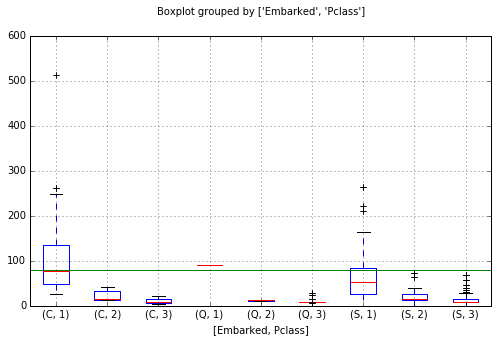

In [358]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax = data.boxplot(column='Fare', by=['Embarked','Pclass'], ax=ax)
plt.axhline(y=80, color='green')
ax.set_title('', y=1.1)

data[data.Embarked.isnull()][['Fare', 'Pclass', 'Embarked']]

####From the above boxplot, we should replace NA with C because most people who had Pclass 1 and Fare 80 would be Embarked C

In [359]:
data['Embarked'].fillna('C', inplace=True)

##Missing values on Fare

,Pclass,Fare,Embarked
1043,3,NaN,S


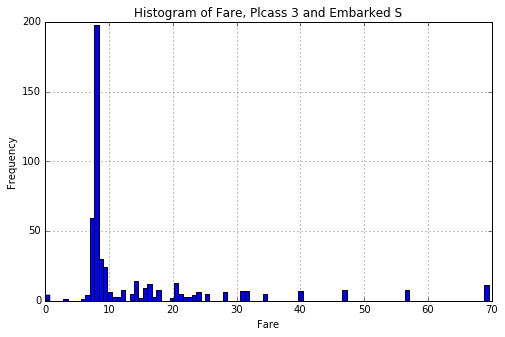

In [360]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
data[(data.Pclass==3)&(data.Embarked=='S')].Fare.hist(bins=100, ax=ax)
data[data.Fare.isnull()][['Pclass', 'Fare', 'Embarked']]
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare, Plcass 3 and Embarked S')

data[data.Fare.isnull()][['Pclass', 'Fare', 'Embarked']]

In [361]:
print ("The top 5 most common value of Fare")
data[(data.Pclass==3)&(data.Embarked=='S')].Fare.value_counts().head()

The top 5 most common value of Fare


8.0500    60
7.8958    43
7.7750    26
7.9250    23
7.8542    21
Name: Fare, dtype: int64

In [362]:
data['Fare'].fillna(8.05, inplace=True)

###Replace the missing value of Cabin with U0

In [363]:
data['Cabin_Missing'] = data['Cabin'].apply(lambda x: 1 if pd.isnull(x) else 0)
data['Cabin'].fillna('U0', inplace=True)

##Feature Engineering

###Create a feature, Names, to store the length of words in name.

In [364]:
import re
data['Names'] = data['Name'].map(lambda x: len(re.split(' ', x)))

###Create a feature, Title.

In [365]:
title = data['Name'].map(lambda x: re.compile(', (.*?)\.').findall(x)[0])
title[title=='Mme'] = 'Mrs'
title[title.isin(['Ms','Mlle'])] = 'Miss'
title[title.isin(['Don', 'Jonkheer'])] = 'Sir'
title[title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'
title[title.isin(['Capt', 'Col', 'Major', 'Dr', 'Officer', 'Rev'])] = 'Officer'
data['Title'] = title
del title

###Create a feature, Deck. It may represents the socioeconomic status.

In [366]:
deck = data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
data['Deck'] = deck
del deck

In [367]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,source,Cabin_Missing,Names,Title,Deck
0,22.0,U0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train,1,4,Mr,U
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train,0,7,Mrs,C
2,26.0,U0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train,1,3,Miss,U
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train,0,7,Mrs,C
4,35.0,U0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train,1,4,Mr,U


###Create a feature, Room. It may represents the geo lacation.

In [368]:
checker = re.compile("([0-9]+)")
def roomNum(x):
    nums = checker.search(x)
    if nums:
        return int(nums.group())+1
    else:
        return 1
rooms = data['Cabin'].map(lambda x: roomNum(x))

In [369]:
data['Cabin_Room'] = rooms / rooms.sum()
del checker, roomNum

In [370]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,source,Cabin_Missing,Names,Title,Deck,Cabin_Room
0,22.0,U0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train,1,4,Mr,U,0.000064
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train,0,7,Mrs,C,0.005496
2,26.0,U0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train,1,3,Miss,U,0.000064
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train,0,7,Mrs,C,0.007924
4,35.0,U0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train,1,4,Mr,U,0.000064


###Create a feature, Group_num. It may represents the size of family.

In [371]:
data['Group_num'] = data['Parch'] + data['SibSp'] + 1

###Create a feature, Group_size. When the size is between 2 and 4, more people are survived.

In [372]:
def groupSize(x):
    if x > 4 :
        return 'L'
    elif x == 1 :
        return 'S'
    else:
        return 'M'
group_size = data['Group_num'].map(lambda x: groupSize(x))
data['Group_size'] = group_size

In [373]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,source,Cabin_Missing,Names,Title,Deck,Cabin_Room,Group_num,Group_size
0,22.0,U0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train,1,4,Mr,U,0.000064,2,M
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train,0,7,Mrs,C,0.005496,2,M
2,26.0,U0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train,1,3,Miss,U,0.000064,1,S
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train,0,7,Mrs,C,0.007924,2,M
4,35.0,U0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train,1,4,Mr,U,0.000064,1,S


In [374]:
data.dtypes

Age              float64
Cabin             object
Embarked          object
Fare             float64
Name              object
Parch              int64
PassengerId        int64
Pclass             int64
Sex               object
SibSp              int64
Survived         float64
Ticket            object
source            object
Cabin_Missing      int64
Names              int64
Title             object
Deck              object
Cabin_Room       float64
Group_num          int64
Group_size        object
dtype: object

###Normalized the fare.

In [375]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['Nor_Fare'] = pd.Series(scaler.fit_transform(data['Fare'].values.reshape(-1,1)).reshape(-1), index=data.index)

###Numerical Coding:

In [376]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_to_encode = ['Embarked','Sex','Deck','Group_size','Title']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

###One-Hot Coding

In [377]:
data = pd.get_dummies(data, columns=var_to_encode)
data.columns

Index([u'Age', u'Cabin', u'Fare', u'Name', u'Parch', u'PassengerId', u'Pclass',
       u'SibSp', u'Survived', u'Ticket', u'source', u'Cabin_Missing', u'Names',
       u'Cabin_Room', u'Group_num', u'Nor_Fare', u'Embarked_0', u'Embarked_1',
       u'Embarked_2', u'Sex_0', u'Sex_1', u'Deck_0', u'Deck_1', u'Deck_2',
       u'Deck_3', u'Deck_4', u'Deck_5', u'Deck_6', u'Deck_7', u'Deck_8',
       u'Group_size_0', u'Group_size_1', u'Group_size_2', u'Title_0',
       u'Title_1', u'Title_2', u'Title_3', u'Title_4', u'Title_5', u'Title_6'],
      dtype='object')

###Predict Age

In [378]:
label_y = data[data['source'] == 'train']['Survived']

In [379]:
from sklearn.model_selection import train_test_split
data.drop(labels=['PassengerId', 'Name', 'Cabin', 'Survived', 'Ticket', 'Fare'], axis=1, inplace=True)

X = data[data['Age'].notnull()].drop(['Age','source'], axis=1)
y = data[data['Age'].notnull()].Age
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def get_model(estimator, parameters, X_train, y_train, scoring):  
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_

import xgboost as xgb

XGB = xgb.XGBRegressor(max_depth=4, seed= 42)
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
parameters = {'reg_alpha':np.linspace(0.1,1.0,5), 'reg_lambda': np.linspace(1.0,3.0,5)}
reg_xgb = get_model(XGB, parameters, X_train, y_train, scoring)
print (reg_xgb)

print ("Mean absolute error of test data: {}".format(mean_absolute_error(y_test, reg_xgb.predict(X_test))))

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0.77500000000000002,
       reg_lambda=3.0, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)
Mean absolute error of test data: 7.74417822386


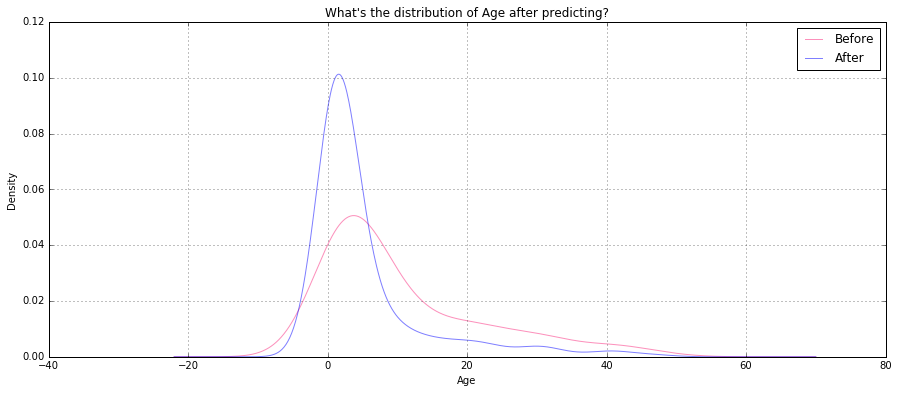

In [380]:
fig = plt.figure(figsize=(15, 6))
alpha = 0.5
data['Age'].value_counts().plot(kind='density', color='#FA2379', label='Before', alpha=alpha)

pred = reg_xgb.predict(data[data['Age'].isnull()].drop(['Age','source'], axis=1))
data.set_value(data['Age'].isnull(), 'Age', pred)

data['Age'].value_counts().plot(kind='density', label='After', alpha=alpha)
plt.xlabel('Age')
plt.title("What's the distribution of Age after predicting?" )
plt.legend(loc='best')
plt.grid()

###Separate train & test:

In [381]:
# label_y
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']

train.drop('source',axis=1,inplace=True)
test.drop('source',axis=1,inplace=True)

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


##Build Model

In [382]:
def modelfit(alg, train, label_y,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train, label=label_y)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train, label_y,eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(train)
    dtrain_predprob = alg.predict_proba(train)[:,1]
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(label_y, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(label_y, dtrain_predprob)
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9046
AUC Score (Train): 0.965328


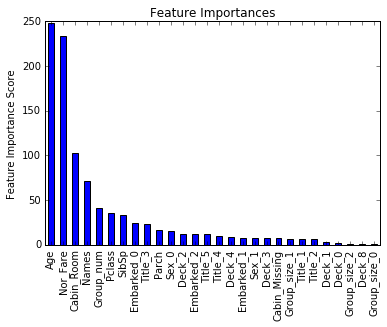

In [383]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
#         scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, label_y)

In [384]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train,label_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87893, std: 0.03059, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.87536, std: 0.02634, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.87735, std: 0.02502, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87243, std: 0.02958, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87618, std: 0.02258, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.87828, std: 0.02639, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.87385, std: 0.02618, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.87551, std: 0.02419, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.87715, std: 0.02570, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.87136, std: 0.02637, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.87752, std: 0.02349, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.87897, std: 0.02562, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 5

In [385]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[8,9,10,11,12],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train,label_y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87625, std: 0.02361, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.87830, std: 0.02551, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.87881, std: 0.02742, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: 0.87717, std: 0.02553, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: 0.87897, std: 0.02562, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.87856, std: 0.02724, params: {'max_depth': 9, 'min_child_weight': 6},
  mean: 0.87505, std: 0.02526, params: {'max_depth': 10, 'min_child_weight': 4},
  mean: 0.87940, std: 0.02613, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.87856, std: 0.02724, params: {'max_depth': 10, 'min_child_weight': 6},
  mean: 0.87590, std: 0.02531, params: {'max_depth': 11, 'min_child_weight': 4},
  mean: 0.87940, std: 0.02613, params: {'max_depth': 11, 'min_child_weight': 5},
  mean: 0.87856, std: 0.02724, params: {'max_depth': 11, 'min_child_weight': 6},
  mean: 0.87590, std: 0.02531, par

In [386]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,15)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=10,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train,label_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87940, std: 0.02613, params: {'gamma': 0.0},
  mean: 0.87902, std: 0.02441, params: {'gamma': 0.1},
  mean: 0.87987, std: 0.02615, params: {'gamma': 0.2},
  mean: 0.87834, std: 0.02624, params: {'gamma': 0.3},
  mean: 0.88052, std: 0.02710, params: {'gamma': 0.4},
  mean: 0.87906, std: 0.02691, params: {'gamma': 0.5},
  mean: 0.87959, std: 0.02701, params: {'gamma': 0.6},
  mean: 0.87720, std: 0.02630, params: {'gamma': 0.7},
  mean: 0.87982, std: 0.02703, params: {'gamma': 0.8},
  mean: 0.88144, std: 0.02722, params: {'gamma': 0.9},
  mean: 0.88019, std: 0.02646, params: {'gamma': 1.0},
  mean: 0.87760, std: 0.02703, params: {'gamma': 1.1},
  mean: 0.87982, std: 0.02778, params: {'gamma': 1.2},
  mean: 0.87996, std: 0.02759, params: {'gamma': 1.3},
  mean: 0.87910, std: 0.02855, params: {'gamma': 1.4}],
 {'gamma': 0.9},
 0.88143902243059902)


Model Report
Accuracy : 0.8866
AUC Score (Train): 0.943739


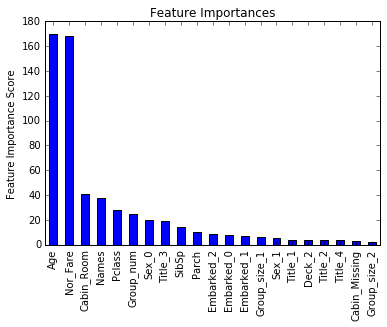

In [387]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=10,
        min_child_weight=5,
        gamma=0.9,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        seed=27)
modelfit(xgb2, train, label_y)

In [388]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train,label_y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87746, std: 0.02949, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.87543, std: 0.02824, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.87706, std: 0.02779, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.87699, std: 0.02588, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.87631, std: 0.02650, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.88022, std: 0.02611, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.87843, std: 0.02938, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.87687, std: 0.02696, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.87708, std: 0.02594, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.87841, std: 0.02662, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.87855, std: 0.02866, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.87633, std: 0.02571, params: {'subsample': 0.9, 'colsample_bytree'

In [389]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train,label_y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87833, std: 0.02850, params: {'reg_alpha': 1e-05},
  mean: 0.87540, std: 0.02777, params: {'reg_alpha': 0.01},
  mean: 0.87970, std: 0.02898, params: {'reg_alpha': 0.1},
  mean: 0.87932, std: 0.02736, params: {'reg_alpha': 1},
  mean: 0.79067, std: 0.03408, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.87969533790235821)

In [390]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[0, 0.01, 0.05, 0.1, 0.16, 0.19]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train,label_y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/Users/wy/anaconda/envs/condapy2.7/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87833, std: 0.02850, params: {'reg_alpha': 0},
  mean: 0.87540, std: 0.02777, params: {'reg_alpha': 0.01},
  mean: 0.87725, std: 0.02746, params: {'reg_alpha': 0.05},
  mean: 0.87970, std: 0.02898, params: {'reg_alpha': 0.1},
  mean: 0.87948, std: 0.02727, params: {'reg_alpha': 0.16},
  mean: 0.87817, std: 0.02814, params: {'reg_alpha': 0.19}],
 {'reg_alpha': 0.1},
 0.87969533790235821)


Model Report
Accuracy : 0.8866
AUC Score (Train): 0.948585


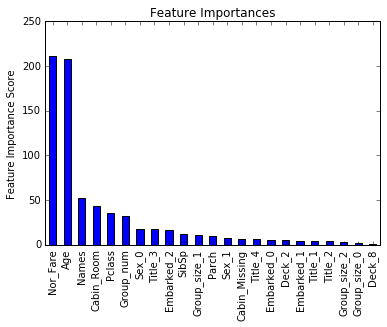

In [391]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=10,
        min_child_weight=5,
        gamma=0.9,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        objective= 'binary:logistic',
        nthread=4,
        seed=27)
modelfit(xgb3, train, label_y)


Model Report
Accuracy : 0.8462
AUC Score (Train): 0.887035


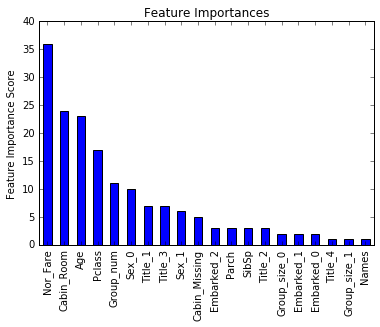

In [392]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=10,
        min_child_weight=5,
        gamma=0.9,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, train, label_y)

##Make submission

In [393]:
test_predict = xgb4.predict(test)

In [394]:
submission = pd.DataFrame({
        "PassengerId": test_passengerId,
        "Survived": test_predict
    })

In [402]:
submission['Survived'] = submission['Survived'].astype('int64')

In [404]:
submission.to_csv('/Users/wy/Desktop/titanic_xgboost2.csv', index=False)